In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib._image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

## Data Preparation:

Load the data:

In [2]:
#Loading the data
train = pd.read_csv('C:\\Users\\Kush\\Dropbox\\digits\\mnist_train.csv', header=None)
test = pd.read_csv('C:\\Users\\Kush\\Dropbox\\digits\\mnist_test.csv', header=None)

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: 0, dtype: int64

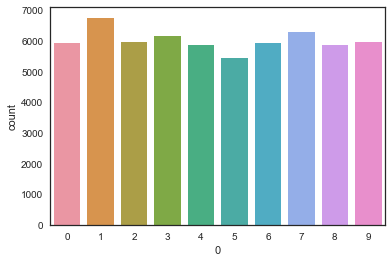

In [3]:
Y_train = train[0]
X_train = train.drop(0, axis=1)

Y_test = test[0]
test = test.drop(0, axis=1)

#free some space
del train

sns.countplot(Y_train)
Y_train.value_counts()

### Check for Null and missing values

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

So from this, we can see that there are no missing values. Let's move ahead.

## Normalization

Here, I've performed grayscale normalization because all the images are grayscaled. The reason behind performing normalization here is that CNN converges faster on a scale of [0,1] than on a scale of [0,255].

In [6]:
X_train = X_train/255.0
test = test/255.0

## Reshape

In [7]:
# Reshape images into 3 dimensions (height=28px, width=28px, canal=1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Here, *canal* represents the number of channels. In our case, images are grayscaled and so canal=1. If the images would have been RGB format, we would have used canal=3. *-1* just indicates that we're telling python to figure one of the dimensions on it's own.

## Label Encoding

In [8]:
# Convert labels into one hot vectors
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

Here, we have succesfully one-hot-encoded the lables. For example a digit 2 would get encoded as [0,0,1,0,0,0,0,0,0,0].

Let's have a quick look at how images actually look in our dataset.

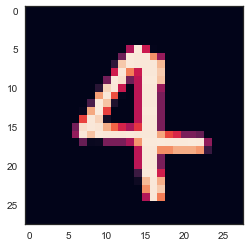

In [12]:
plt.imshow(X_train[6,:,:,0])

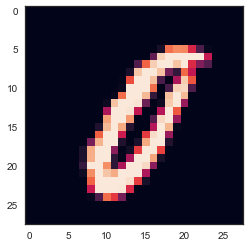

In [13]:
plt.imshow(test[6,:,:,0])

## CNN

I have used Keras API here.

The first is the convolutional (Conv2D) layer. I chose 32 filters for the first two convolutional layers and 64 for the last two. Then the kernel filter (convolutional filter) is applied on the whole image. 

The second important layer is the pooling layer. This one simply acts as a downsampling filter which means that it reduces the dimensions of the matrix. It looks at the two neighboring pixels because of 2X2 matrix size and picks the maximum value. More the dimension of pooling layer matrix, more will be the overall reduction.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

I've also used the dropout regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

The activation function used here is *ReLu*. 

In [9]:
### The CNN model
### My CNN model architecture
# In -> [[Conv2D->ReLu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=6, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=6, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
# Defining the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08,decay=0.0)

In [11]:
# Compiling the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence.

It's better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [12]:
# Setting the learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',verbose=1,patience=3, factor=0.5, min_lr=0.00001)

In [13]:
epochs = 1
batch_size = 80

In [14]:
for i, layer in enumerate(model.layers):
    layer.name = 'layer_' + str(i)
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (Conv2D)             (None, 28, 28, 32)        832       
_________________________________________________________________
layer_1 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
layer_2 (MaxPooling2D)       (None, 14, 14, 32)        0         
_________________________________________________________________
layer_3 (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
layer_4 (Conv2D)             (None, 14, 14, 6)         1734      
_________________________________________________________________
layer_5 (Conv2D)             (None, 14, 14, 6)         330       
_________________________________________________________________
layer_6 (MaxPooling2D)       (None, 7, 7, 6)           0         
__________

In [15]:
X_train.shape

(60000, 28, 28, 1)

In [16]:
model_train = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs = epochs,
          verbose=2)

Epoch 1/1
 - 1488s - loss: 0.3289 - acc: 0.8970


In [17]:
from keras import Model

intermediate_layer_model = Model(inputs = model_train.model.input, outputs = model_train.model.get_layer('layer_5').output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [22]:
intermediate_output_test = intermediate_layer_model.predict(test)

In [18]:
intermediate_output.shape

(60000, 14, 14, 6)

In [23]:
intermediate_output_test.shape

(10000, 14, 14, 6)

In [19]:
intermediate_output

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.84417516e-03, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.61338225e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.88753510e-01, 1.88697112e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 1.22403872e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          6.39234856e-03, 0.00000000e+00, 3.95929396e-01]],

        [[0.00000000e+00, 4.85114977e-02, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.15883477e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 9.14398804e-02, 9.4204

In [24]:
intermediate_output_test

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.31840006e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.11094511e-01, 0.00000000e+00, 1.46912187e-02,
          1.50384195e-02, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.92898007e-02, 6.43273741e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 5.80276400e-02, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.33512342e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.08284542e-01, 2.83491552e-01, 3.6852

In [20]:
layer_5 = np.reshape(intermediate_output, (intermediate_output.shape[0],-1))

In [26]:
layer_5_test = np.reshape(intermediate_output_test, (intermediate_output_test.shape[0],-1))

In [ ]:
np.savetxt('Layer_5.csv', layer_5, delimiter=',')

In [27]:
np.savetxt('Layer_5_test.csv', layer_5_test, delimiter=',')